In [40]:
# Importing all libraries

import numpy as np 
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from Functions import *

In [42]:
#============== System parameters
'''
Defining Parameters
    Nt = Number of transmit antennas (SISO = 1)
    K = Number of Users
    BW = Bandwidth
    NF = Noise Floor
    ALPHA = PLE for indirect link (IRS-1)
    BETA = PLE for indirect link (IRS-2)
    ZETA = PLE for direct link 
    wn = efficiency of transmit power amplifier
    Pb = Power dissipated by BS
    Pu = Power dissipated by User
    loc_U = User positions
    m = Nakagami Shape parameter (m > 0, m = 1 corresponds to Rayleigh fading)
    omega = 1.0  Nakagami Spread parameter (omega > 0)
    Ns_max = Total number of IRS elements in a single IRS

'''
Nt = 1
K = 16

# gamma = db2pow(20)
f = 2.4e9
c = 3e8
Lambda = c/f
halfLambda = 0.5*Lambda
quarterLambda = 0.25*Lambda
BW = 20e6
NF = 10 
noise = -174+10*np.log10(BW) + NF

# Network Parameters
GRID_RADIUS = 1000
BASE_STATION_POSITION = (0, 0, 20)
TRANSMIT_POWER_WATTS = 4 #in watts (For other cases, change power from 0.1 to 4)
NUM_SIMULATIONS = 10
dThreshold = GRID_RADIUS/ 2 # Changed from 40 to 20

# Fading Paramters
FADING_STD_MEAN = 0
FADING_STD_DEV = 3
m = 2 #Changed the shape from 1 to 2
omega = np.sqrt(0.5)

# Path Loss Parameters
BETA_1 = 2.2 #path loss exponent (BS to IRSs)
BETA_2 = 2.8 #path loss exponent  (IRSs to user)
ALPHA = 3.8 #path loss exponent  (BS to user)

# IRS Positions
IRS_POSITION_1 = (60, 80, 10)
IRS_POSITION_2 = (60, -80, 10)
Ns_max = 289

# Power consumption params
wn = 0.5
Pb = 10 # in dBw
Pu = 10 # 10 in dBm

#Practical phase shift model paramters
a = 1.6
phi = 0.43 * np.pi
B_min = 0.2

Plotting the Network

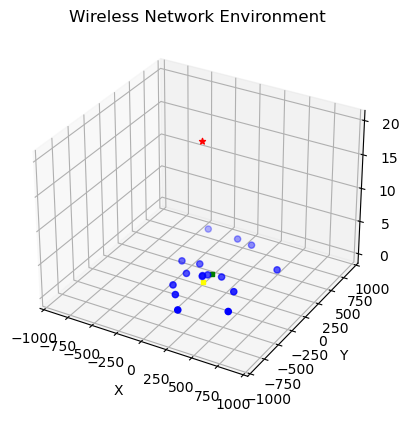

In [43]:

xt, yt, zt = BASE_STATION_POSITION
xs_1, ys_1, zs_1 = IRS_POSITION_1
xs_2, ys_2, zs_2 = IRS_POSITION_2


USER_POS = generate_user_positions_3D(K, GRID_RADIUS)
fig = plt.figure()
ax = plt.axes(projection ="3d")
ax.scatter3D(USER_POS[:, 0], USER_POS[:, 1], color='blue', marker='o', label='Users')
ax.scatter(xt, yt, zt, color='red', marker='*', label='Base Station')
plt.scatter(xs_1, ys_1, zs_1, color='green', marker='s', label='IRS_1')
plt.scatter(xs_2, ys_2, zs_2, color='yellow', marker='s', label='IRS_2')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.axis([-1000,1000,-1000,1000])
ax.set_title('Wireless Network Environment')
# ax.legend()
ax.grid(True)

# print('User positions:'"\n" , USER_POS)
# print('BS position:'"\n" , BASE_STATION_POSITION)
# print('IRS-1 position:'"\n" , IRS_POSITION_1)
# print('IRS-2 position:'"\n" , IRS_POSITION_2)

loc_T = np.array([BASE_STATION_POSITION])
loc_U = USER_POS

dTU = np.zeros((1,K))
for m in range(K):
    dTU[:,m] = calc_distance_3D(USER_POS[m],BASE_STATION_POSITION)

# print('BS to User distance dTU:'"\n" , dTU)



Generating Channels

In [44]:


h_dk_3d = np.zeros((NUM_SIMULATIONS,K,1), dtype= np.complex128)
h_rk1_3d = np.zeros((NUM_SIMULATIONS,Ns_max,K), dtype= np.complex128)
h_rk1_h_3d = np.zeros((NUM_SIMULATIONS,K,Ns_max), dtype= np.complex128)
G1_3d = np.zeros((NUM_SIMULATIONS,Ns_max,1), dtype= np.complex128)
h_rk2_3d = np.zeros((NUM_SIMULATIONS,Ns_max,K), dtype= np.complex128)
h_rk2_h_3d = np.zeros((NUM_SIMULATIONS,K,Ns_max), dtype= np.complex128) 
G2_3d = np.zeros((NUM_SIMULATIONS,Ns_max,1), dtype= np.complex128)



# Perform simulations
for i in range(NUM_SIMULATIONS):

    # Generate the Rayleigh Fading Channel for each user (h_dk)
    h_dk = np.zeros((K,1))
    # h_dk = np.array(generate_rayleigh_fading_channel(K,FADING_STD_MEAN,FADING_STD_DEV))
    # for m in range(K):
    #     if(dTU[:,m] > dThreshold):
    #         h_dk[m] = 0
    #     else:
    #         h_dk[m] = h_dk[m]
    # h_dk = np.reshape(h_dk ,(K,1))
    # h_dk_3d[i] = h_dk
    
    # Generate the Nakagami Channel from each user to the IRS-1 (h_rk1)
    fading = []
    for user in range(K):
        fading.append(generate_rayleigh_fading_channel(Ns_max,FADING_STD_MEAN,FADING_STD_DEV)) 
    h_rk1 = fading
    h_rk1 = np.reshape(h_rk1,(Ns_max,K))
    h_rk1_transpose = np.transpose(h_rk1)
    h_rk1_h = np.conj(h_rk1_transpose)
    h_rk1_3d[i] = h_rk1
    h_rk1_h_3d[i] = h_rk1_h


    # Generate the Nakagami Channel from each user to the IRS-2 (h_rk2)
    fading = []
    for user in range(K):
        fading.append(generate_rayleigh_fading_channel(Ns_max,FADING_STD_MEAN,FADING_STD_DEV)) 
    h_rk2 = fading
    h_rk2 = np.reshape(h_rk2,(Ns_max,K))
    h_rk2_transpose = np.transpose(h_rk2)
    h_rk2_h = np.conj(h_rk2_transpose)
    h_rk2_3d[i] = h_rk2
    h_rk2_h_3d[i] = h_rk2_h

    # Generate the Nakagami Channel from base_station to the IRS-1 (G1)
    G1 = generate_rayleigh_fading_channel(Ns_max,FADING_STD_MEAN,FADING_STD_DEV) 
    G1 = np.reshape(G1,(Ns_max,1))
    G1_3d[i] = G1

    # Generate the Nakagami Channel from base_station to the IRS-2 (G2)
    G2 = generate_rayleigh_fading_channel(Ns_max,FADING_STD_MEAN,FADING_STD_DEV)
    G2 = np.reshape(G2,(Ns_max,1))
    G2_3d[i] = G2

print('Size of hdk3d', np.shape(h_dk_3d))
print('Size of hrk3d', np.shape(h_rk1_3d))
print('Size of hrkh3d', np.shape(h_rk1_h_3d))
print('Size of g3d', np.shape(G1_3d))




Size of hdk3d (10, 16, 1)
Size of hrk3d (10, 289, 16)
Size of hrkh3d (10, 16, 289)
Size of g3d (10, 289, 1)


In [45]:
h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

        # BS to IRS
G1_ns_values = [G1_3d[s][:Ns_max, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
G2_ns_values = [G2_3d[s][:Ns_max, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

        # IRS to Users
h_rk1_ns_values = [h_rk1_3d[s][:, :Ns_max] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
h_rk2_ns_values = [h_rk2_3d[s][:, :Ns_max] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)    
h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns_max] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
h_rk2_h_ns_values = [h_rk2_h_3d[s][:, :Ns_max] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)

In [46]:
print(np.shape(h_dk_3d))

(10, 16, 1)


Simulations for Ideal Continuos Case, Double IRS

In [55]:
RATE_THRESHOLD = 10
B = 2
Ns_max_sqrt = int(np.sqrt(Ns_max))
N_values = np.array([i**2 for i in range(4, Ns_max_sqrt + 1)])
Pt = np.arange(0,51,2)
print(N_values)


arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))


    # Create a set of quantized theta values
    # quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    # print('Quantized_theta_set: ',"\n", (quantized_theta_set))

# Initialize an empty dictionary to store the results
results_dict_1 = {}
results_dict_2 = {}
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# ----------------------------------for Quantization Bits = 2,3,4 and different values of IRS elements---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------

quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)

for T in Pt:
    TRANSMIT_POWER_WATTS = dBm2pow(T)
    average_energy_efficiency_1 = []

    for Ns in N_values:
        nIRSrow = int(np.sqrt(Ns))
        nIRScol = nIRSrow
        energy_efficiency = []
# -------------------------------------------------------------Calculating distances-----------------------------------------------------------------------------------
        
        irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_1 = irs_coords_1
        # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
        # print()
        
        irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_2 = irs_coords_2
        # print('IRS 2 elements coordinates:'"\n", loc_S_2) 
        # print()
        
        dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
        dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
        
        # Reshapiing the distance from antennas/BS to user
        dTU = dTU.reshape(Nt,K)
        # Compute row-wise averages
        dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)
        # Compute row-wise averages
        dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
        dSU_2 = dSU_2.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_2 = np.mean(dTS_2, axis=1)
        # Compute the average of row sums
        dTS_2 = np.mean(dTS_2)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values for current Ns value-----------------------------------------------------------------------------------
        # Direct Link
        h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

        # BS to IRS
        G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
        G2_ns_values = [G2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

        # IRS to Users
        h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk2_ns_values = [h_rk2_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
        h_rk2_h_ns_values = [h_rk2_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        
        # Initialize list to store individual outage probabilities
        energy_efficiency = []
        # Initialize sum-rates for this case
        sum_rate = []

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------RUNNING SIMULATIONS---------------------------------------------------------------------------------------------------------------------
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_3d[s] # Shape: (K, 1)
            h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
            h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
            G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

            h_rk2 = h_rk2_ns_values[s]  # Shape: (Ns, K)
            h_rk2_h = h_rk2_h_ns_values[s]  # Shape: (K, Ns)
            G_2 = G2_ns_values[s]  # Shape: (Ns, 1)
            
            theta_1 = theta_matrix_practical(0, h_dk= h_dk , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set)
            theta_2 = theta_matrix_practical(0, h_dk= h_dk , h_rk= h_rk2, g= G_2, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set )


            results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)
            results_array_2 = prod_matrix(theta_2, h_rk2_h, G_2, K, Ns)

        # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
            arr_link_budget = np.zeros((K,1))
            for m in range (K):
                arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((h_dk[m]/np.sqrt(dTU[:,m]**ALPHA)) + ((results_array_1[m]/np.sqrt((dSU_1[:,m]**BETA_2)*(dTS_1**BETA_1)))  + (results_array_2[m]/np.sqrt((dSU_2[:,m]**BETA_2)*(dTS_2**BETA_1))))))
                arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
            arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))

            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_21 = compute_power_consumption_at_ris(B, Ns)
            power_22 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_21 + power_22 + power_3

            ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
            energy_efficiency.append(ee/1e6)
        average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
        average_energy_efficiency_1.append(average_energy_efficiencies_1)


    results_dict_2[T] = average_energy_efficiency_1

print('done')
print(N_values)

[ 16  25  36  49  64  81 100 121 144 169 196 225 256 289]
done
[ 16  25  36  49  64  81 100 121 144 169 196 225 256 289]


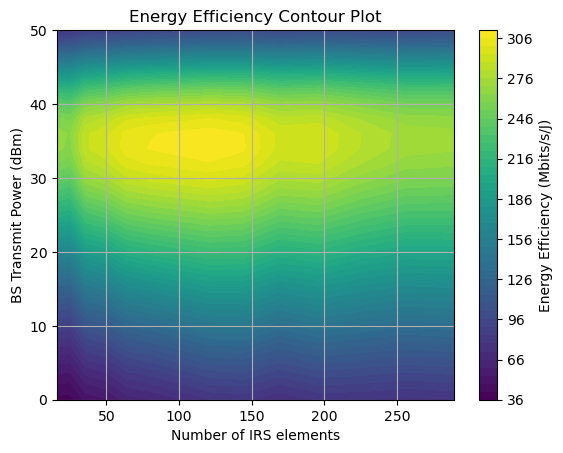

In [56]:
# Extract the values from the dictionary and create a 2D array
energy_efficiency_matrix = np.zeros((len(N_values), len(Pt)))

for i, n_value in enumerate(N_values):
    for j, transmit_power in enumerate(Pt):
        energy_efficiency_matrix[i, j] = results_dict_2[transmit_power][i]

# Create a meshgrid for N and T values
N, Pt = np.meshgrid(N_values, Pt)

# Increase the number of contour levels for smoother appearance
num_levels = 50  # Adjust this number as needed

# Create the contour plot with smooth contours
contour = plt.contourf(N, Pt, energy_efficiency_matrix.T, num_levels, cmap='viridis')
plt.colorbar(contour, label='Energy Efficiency (Mbits/s/J)')

plt.xlabel('Number of IRS elements')
plt.ylabel('BS Transmit Power (dBm)')
plt.title('Energy Efficiency Contour Plot')

plt.grid(True)
plt.show()

In [27]:
np.savetxt('./CSVDataFiles/Nmesh.csv', N, delimiter=',')
np.savetxt('./CSVDataFiles/Ptmesh.csv', Pt, delimiter=',')
np.savetxt('./CSVDataFiles/EE_Double_Ideal.csv', energy_efficiency_matrix, delimiter=',')

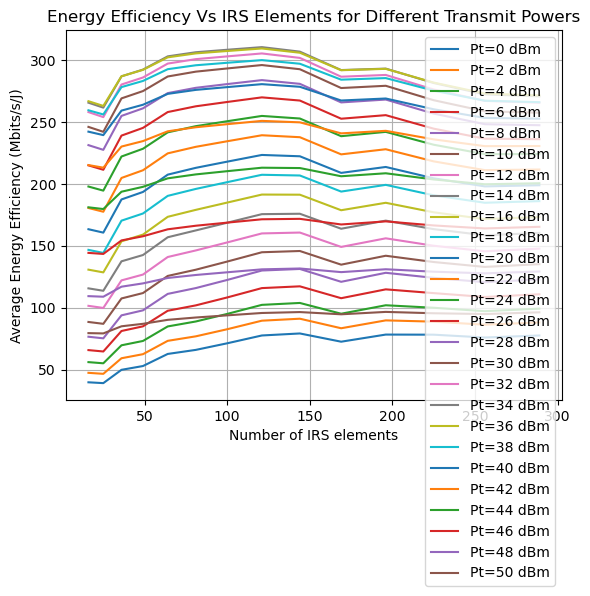

In [57]:
# Plot the graph for each value of T
for T, average_energy_efficiency_1 in results_dict_2.items():
    plt.plot(N_values, average_energy_efficiency_1, label=f'Pt={T} dBm')

plt.ylabel('Average Energy Efficiency (Mbits/s/J)')
plt.xlabel('Number of IRS elements')
plt.title('Energy Efficiency Vs IRS Elements for Different Transmit Powers')
plt.legend()
plt.grid(True)
plt.show()

Simulations for Practical Discrete Case, Double IRS (B = 3)

In [60]:
RATE_THRESHOLD = 10
B = 3
Ns_max_sqrt = int(np.sqrt(Ns_max))
N_values = np.array([i**2 for i in range(4, Ns_max_sqrt + 1)])
Pt = np.arange(0,51,2)
print(N_values)

NUM_SIMULATIONS = 10

arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))




    # Create a set of quantized theta values
    # quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    # print('Quantized_theta_set: ',"\n", (quantized_theta_set))

# Initialize an empty dictionary to store the results
results_dict_1 = {}
results_dict_2 = {}
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# ----------------------------------for Quantization Bits = 2,3,4 and different values of IRS elements---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------

quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)

for T in Pt:
    TRANSMIT_POWER_WATTS = dBm2pow(T)
    average_energy_efficiency_1 = []

    for Ns in N_values:
        nIRSrow = int(np.sqrt(Ns))
        nIRScol = nIRSrow
        energy_efficiency = []
# -------------------------------------------------------------Calculating distances-----------------------------------------------------------------------------------
        
        irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_1 = irs_coords_1
        # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
        # print()
        
        irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_2 = irs_coords_2
        # print('IRS 2 elements coordinates:'"\n", loc_S_2) 
        # print()
        
        dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
        dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
        
        # Reshapiing the distance from antennas/BS to user
        dTU = dTU.reshape(Nt,K)
        # Compute row-wise averages
        dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)
        # Compute row-wise averages
        dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
        dSU_2 = dSU_2.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_2 = np.mean(dTS_2, axis=1)
        # Compute the average of row sums
        dTS_2 = np.mean(dTS_2)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values for current Ns value-----------------------------------------------------------------------------------
        # Direct Link
        h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

        # BS to IRS
        G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
        G2_ns_values = [G2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

        # IRS to Users
        h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk2_ns_values = [h_rk2_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
        h_rk2_h_ns_values = [h_rk2_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        
        # Initialize list to store individual outage probabilities
        energy_efficiency = []
        # Initialize sum-rates for this case
        sum_rate = []

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------RUNNING SIMULATIONS---------------------------------------------------------------------------------------------------------------------
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_3d[s] # Shape: (K, 1)
            h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
            h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
            G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

            h_rk2 = h_rk2_ns_values[s]  # Shape: (Ns, K)
            h_rk2_h = h_rk2_h_ns_values[s]  # Shape: (K, Ns)
            G_2 = G2_ns_values[s]  # Shape: (Ns, 1)
            
            theta_1 = theta_matrix_practical(0, h_dk= h_dk , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set)
            theta_2 = theta_matrix_practical(0, h_dk= h_dk , h_rk= h_rk2, g= G_2, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set )

            results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)
            results_array_2 = prod_matrix(theta_2, h_rk2_h, G_2, K, Ns)
        # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
            arr_link_budget = np.zeros((K,1))
            for m in range (K):
                arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((h_dk[m]/np.sqrt(dTU[:,m]**ALPHA)) + ((results_array_1[m]/np.sqrt((dSU_1[:,m]**BETA_2)*(dTS_1**BETA_1)))  + (results_array_2[m]/np.sqrt((dSU_2[:,m]**BETA_2)*(dTS_2**BETA_1))))))
                arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
            arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))
            
            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_21 = compute_power_consumption_at_ris(B, Ns)
            power_22 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_21 + power_22 + power_3

            ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
            energy_efficiency.append(ee/1e6)
        average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
        average_energy_efficiency_1.append(average_energy_efficiencies_1)


    results_dict_2[T] = average_energy_efficiency_1

print('done')
print(N_values)

[ 16  25  36  49  64  81 100 121 144 169 196 225 256 289]
done
[ 16  25  36  49  64  81 100 121 144 169 196 225 256 289]


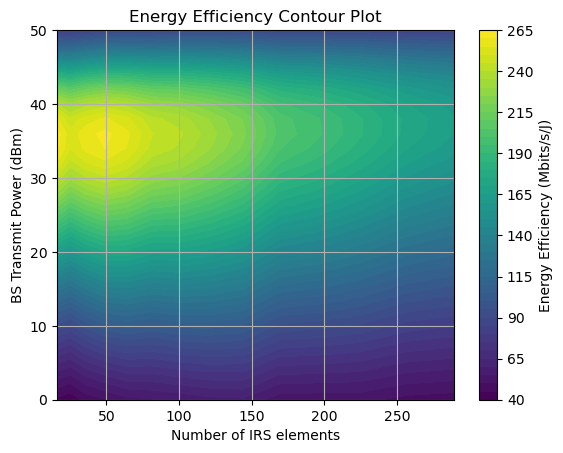

In [61]:
# Extract the values from the dictionary and create a 2D array
energy_efficiency_matrix = np.zeros((len(N_values), len(Pt)))

for i, n_value in enumerate(N_values):
    for j, transmit_power in enumerate(Pt):
        energy_efficiency_matrix[i, j] = results_dict_2[transmit_power][i]

# Create a meshgrid for N and T values
N, Pt = np.meshgrid(N_values, Pt)

# Increase the number of contour levels for smoother appearance
num_levels = 50  # Adjust this number as needed

# Create the contour plot with smooth contours
contour = plt.contourf(N, Pt, energy_efficiency_matrix.T, num_levels, cmap='viridis')
plt.colorbar(contour, label='Energy Efficiency (Mbits/s/J)')

plt.xlabel('Number of IRS elements')
plt.ylabel('BS Transmit Power (dBm)')
plt.title('Energy Efficiency Contour Plot')

plt.grid(True)
plt.show()

In [12]:
np.savetxt('./CSVDataFiles/EE_Double_practB3.csv', energy_efficiency_matrix, delimiter=',')

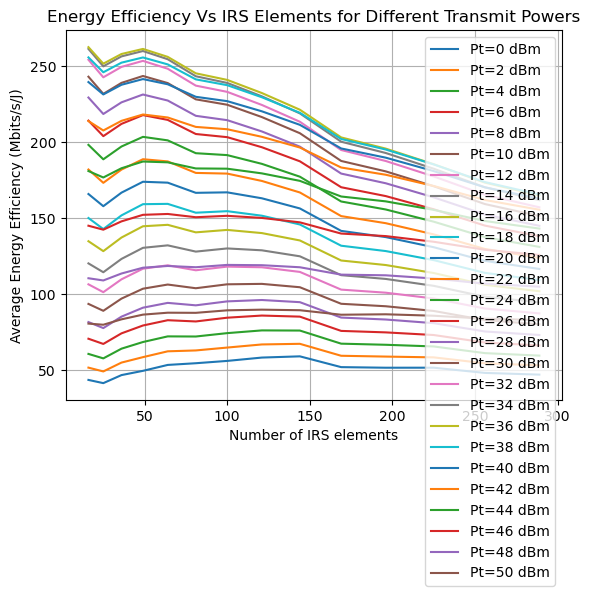

In [62]:
# Plot the graph for each value of T
for T, average_energy_efficiency_1 in results_dict_2.items():
    plt.plot(N_values, average_energy_efficiency_1, label=f'Pt={T} dBm')

plt.ylabel('Average Energy Efficiency (Mbits/s/J)')
plt.xlabel('Number of IRS elements')
plt.title('Energy Efficiency Vs IRS Elements for Different Transmit Powers')
plt.legend()
plt.grid(True)
plt.show()

Single IRS Cases

User positions:
 [[-360.95442911  742.39950311    0.        ]
 [  97.46759276 -589.28636081    0.        ]
 [   1.57027622    7.52404458    0.        ]
 [ -37.33048835  720.76551079    0.        ]
 [ -47.62482907 -385.70113433    0.        ]
 [ 489.51916968 -391.82570355    0.        ]
 [-142.06074307  -32.23486848    0.        ]
 [-285.66420208  132.49323382    0.        ]
 [ 532.31134256  426.4925519     0.        ]
 [   6.11630183   -5.29693382    0.        ]
 [ 126.37961682  688.83959477    0.        ]
 [ 160.40264201   72.39173091    0.        ]
 [-147.15523249 -258.72802141    0.        ]
 [ 374.0620997   -87.38863606    0.        ]
 [  35.39588292   41.25449377    0.        ]
 [-119.58171954  167.37057458    0.        ]]
BS position:
 (0, 0, 20)
IRS-1 position:
 (60, 80, 10)


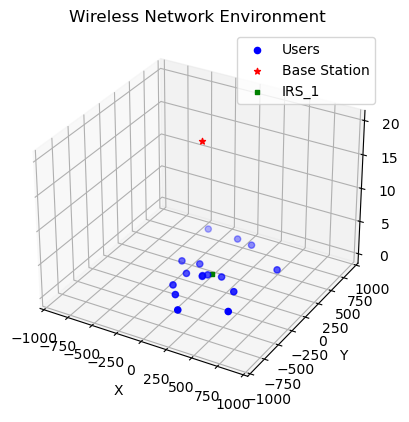

In [63]:

xt, yt, zt = BASE_STATION_POSITION
xs_1, ys_1, zs_1 = IRS_POSITION_1

fig = plt.figure()
ax = plt.axes(projection ="3d")
ax.scatter3D(USER_POS[:, 0], USER_POS[:, 1], color='blue', marker='o', label='Users')
ax.scatter(xt, yt, zt, color='red', marker='*', label='Base Station')
plt.scatter(xs_1, ys_1, zs_1, color='green', marker='s', label='IRS_1')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.axis([-1000,1000,-1000,1000])
ax.set_title('Wireless Network Environment')
plt.legend()
# ax.legend()
ax.grid(True)

print('User positions:'"\n" , USER_POS)
print('BS position:'"\n" , BASE_STATION_POSITION)
print('IRS-1 position:'"\n" , IRS_POSITION_1)

loc_T = np.array([BASE_STATION_POSITION])
loc_U = USER_POS



Extracting Channels from Single IRS

In [64]:
h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

        # BS to IRS
G1_ns_values = [G1_3d[s][:Ns_max, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)


        # IRS to Users
h_rk1_ns_values = [h_rk1_3d[s][:, :Ns_max] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns_max] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)


Simulations for Ideal Continuos Case, Single IRS

In [35]:
RATE_THRESHOLD = 10
B = 2
Ns_max_sqrt = int(np.sqrt(Ns_max))
N_values = np.array([i**2 for i in range(10, Ns_max_sqrt + 1)])
Pt = np.arange(0,51,2)
print(N_values)


arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))



# Create a set of quantized theta values
quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
# print('Quantized_theta_set: ',"\n", (quantized_theta_set))

# Initialize an empty dictionary to store the results
results_dict_1 = {}
results_dict_2 = {}
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# ----------------------------------for Quantization Bits = 2,3,4 and different values of IRS elements---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------

# quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)

for T in Pt:
    TRANSMIT_POWER_WATTS = dBm2pow(T)
    average_energy_efficiency_1 = []

    for Ns in N_values:
        nIRSrow = int(np.sqrt(Ns))
        nIRScol = nIRSrow
        energy_efficiency = []
# -------------------------------------------------------------Calculating distances-----------------------------------------------------------------------------------
        
        irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_1 = irs_coords_1
        # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
        # print()
        
        dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)

        
        # Reshapiing the distance from antennas/BS to user
        dTU = dTU.reshape(Nt,K)
        # Compute row-wise averages
        dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)


# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values for current Ns value-----------------------------------------------------------------------------------
        # Direct Link
        h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

        # BS to IRS
        G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

        # IRS to Users
        h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        
        # Initialize list to store individual outage probabilities
        energy_efficiency = []
        # Initialize sum-rates for this case
        sum_rate = []

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------RUNNING SIMULATIONS---------------------------------------------------------------------------------------------------------------------
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_3d[s] # Shape: (K, 1)
            h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
            h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
            G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

            h_rk2 = h_rk2_ns_values[s]  # Shape: (Ns, K)
            h_rk2_h = h_rk2_h_ns_values[s]  # Shape: (K, Ns)
            G_2 = G2_ns_values[s]  # Shape: (Ns, 1)
            
            theta_1 = theta_matrix_practical(0, h_dk= h_dk , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set)
            results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)

        # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
            arr_link_budget = np.zeros((K,1))
            for m in range (K):
                arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((h_dk[m]/np.sqrt(dTU[:,m]**ALPHA)) + ((results_array_1[m]/np.sqrt((dSU_1[:,m]**BETA_2)*(dTS_1**BETA_1))))))
                arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
            arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))

            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_21 = compute_power_consumption_at_ris(B, Ns)
            power_22 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_21 + power_22 + power_3

            ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
            energy_efficiency.append(ee/1e6)
        average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
        average_energy_efficiency_1.append(average_energy_efficiencies_1)


    results_dict_2[T] = average_energy_efficiency_1

print('done')
print(N_values)

[100 121 144 169 196 225 256 289]
done
[100 121 144 169 196 225 256 289]


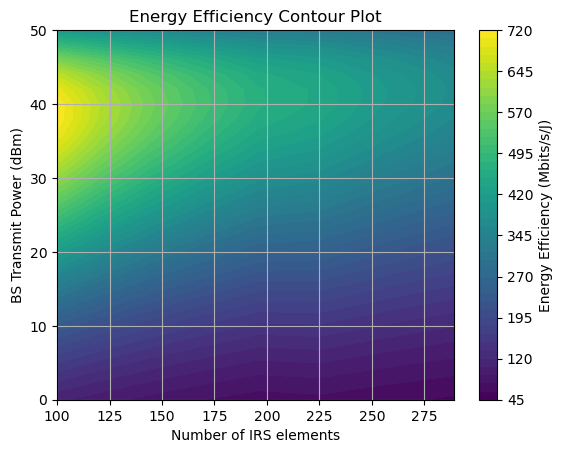

In [36]:
# Extract the values from the dictionary and create a 2D array
energy_efficiency_matrix = np.zeros((len(N_values), len(Pt)))

for i, n_value in enumerate(N_values):
    for j, transmit_power in enumerate(Pt):
        energy_efficiency_matrix[i, j] = results_dict_2[transmit_power][i]

# Create a meshgrid for N and T values
N, Pt = np.meshgrid(N_values, Pt)

# Increase the number of contour levels for smoother appearance
num_levels = 50  # Adjust this number as needed

# Create the contour plot with smooth contours
contour = plt.contourf(N, Pt, energy_efficiency_matrix.T, num_levels, cmap='viridis')
plt.colorbar(contour, label='Energy Efficiency (Mbits/s/J)')

plt.xlabel('Number of IRS elements')
plt.ylabel('BS Transmit Power (dBm)')
plt.title('Energy Efficiency Contour Plot')

plt.grid(True)
plt.show()

In [37]:
np.savetxt('./CSVDataFiles/EE_Single_Ideal.csv', energy_efficiency_matrix, delimiter=',')

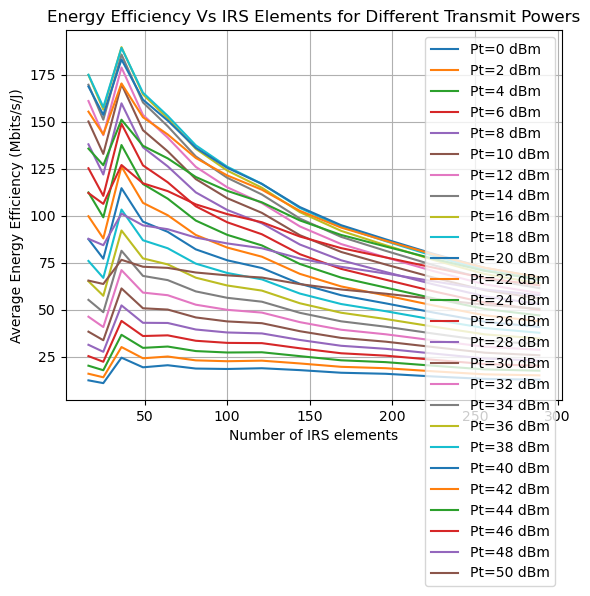

In [16]:
# Plot the graph for each value of T
for T, average_energy_efficiency_1 in results_dict_2.items():
    plt.plot(N_values, average_energy_efficiency_1, label=f'Pt={T} dBm')

plt.ylabel('Average Energy Efficiency (Mbits/s/J)')
plt.xlabel('Number of IRS elements')
plt.title('Energy Efficiency Vs IRS Elements for Different Transmit Powers')
plt.legend()
plt.grid(True)
plt.show()

Simulations for Practical Discrete Case, Single IRS

In [38]:
RATE_THRESHOLD = 10
B = 3
Ns_max_sqrt = int(np.sqrt(Ns_max))
N_values = np.array([i**2 for i in range(10, Ns_max_sqrt + 1)])
Pt = np.arange(0,51,2)
print(N_values)


arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))



    # Create a set of quantized theta values
    # quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    # print('Quantized_theta_set: ',"\n", (quantized_theta_set))

# Initialize an empty dictionary to store the results
results_dict_1 = {}
results_dict_2 = {}
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# ----------------------------------for Quantization Bits = 2,3,4 and different values of IRS elements---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------

quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)

for T in Pt:
    TRANSMIT_POWER_WATTS = dBm2pow(T)
    average_energy_efficiency_1 = []

    for Ns in N_values:
        nIRSrow = int(np.sqrt(Ns))
        nIRScol = nIRSrow
        energy_efficiency = []
# -------------------------------------------------------------Calculating distances-----------------------------------------------------------------------------------
        
        irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_1 = irs_coords_1
        # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
        # print()
        
        dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)

        
        # Reshapiing the distance from antennas/BS to user
        dTU = dTU.reshape(Nt,K)
        # Compute row-wise averages
        dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)


# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values for current Ns value-----------------------------------------------------------------------------------
        # Direct Link
        h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

        # BS to IRS
        G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

        # IRS to Users
        h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        
        # Initialize list to store individual outage probabilities
        energy_efficiency = []
        # Initialize sum-rates for this case
        sum_rate = []

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------RUNNING SIMULATIONS---------------------------------------------------------------------------------------------------------------------
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_3d[s] # Shape: (K, 1)
            h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
            h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
            G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

            theta_1 = theta_matrix_practical(0, h_dk= h_dk , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set)
            results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)
        # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
            arr_link_budget = np.zeros((K,1))
            for m in range (K):
                arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((h_dk[m]/np.sqrt(dTU[:,m]**ALPHA)) + ((results_array_1[m]/np.sqrt((dSU_1[:,m]**BETA_2)*(dTS_1**BETA_1))))))
                arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
            arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))

            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_21 = compute_power_consumption_at_ris(B, Ns)
            power_22 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_21 + power_22 + power_3

            ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
            energy_efficiency.append(ee/1e6)
        average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
        average_energy_efficiency_1.append(average_energy_efficiencies_1)


    results_dict_2[T] = average_energy_efficiency_1

print('done')
print(N_values)

[100 121 144 169 196 225 256 289]
done
[100 121 144 169 196 225 256 289]


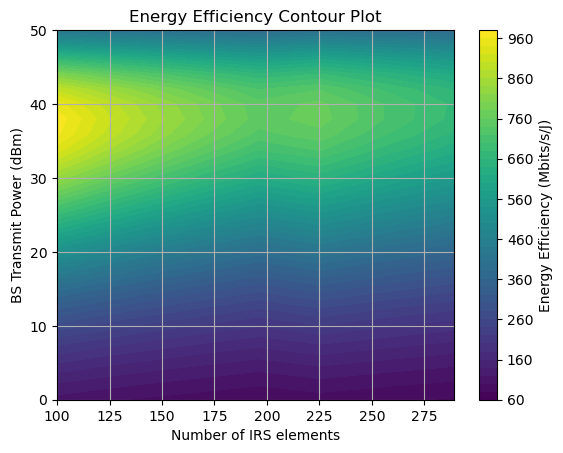

In [39]:
# Extract the values from the dictionary and create a 2D array
energy_efficiency_matrix = np.zeros((len(N_values), len(Pt)))

for i, n_value in enumerate(N_values):
    for j, transmit_power in enumerate(Pt):
        energy_efficiency_matrix[i, j] = results_dict_2[transmit_power][i]

# Create a meshgrid for N and T values
N, Pt = np.meshgrid(N_values, Pt)

# Increase the number of contour levels for smoother appearance
num_levels = 50  # Adjust this number as needed

# Create the contour plot with smooth contours
contour = plt.contourf(N, Pt, energy_efficiency_matrix.T, num_levels, cmap='viridis')
plt.colorbar(contour, label='Energy Efficiency (Mbits/s/J)')

plt.xlabel('Number of IRS elements')
plt.ylabel('BS Transmit Power (dBm)')
plt.title('Energy Efficiency Contour Plot')

plt.grid(True)
plt.show()

In [22]:
np.savetxt('./CSVDataFiles/EE_Single_practB3.csv', energy_efficiency_matrix, delimiter=',')


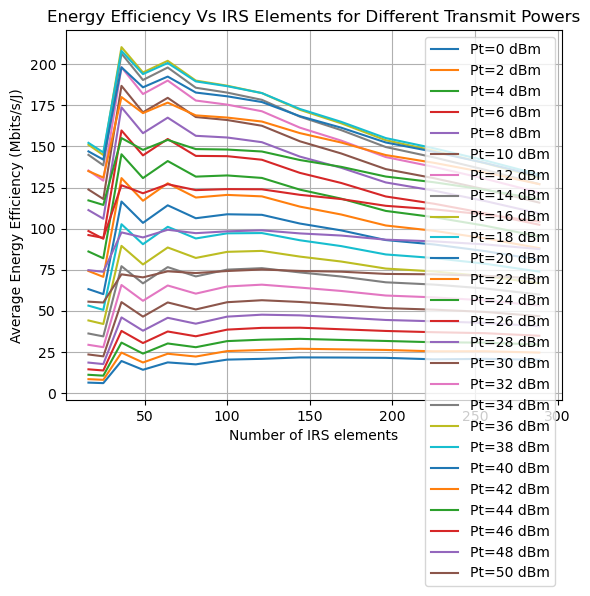

In [19]:
# Plot the graph for each value of T
for T, average_energy_efficiency_1 in results_dict_2.items():
    plt.plot(N_values, average_energy_efficiency_1, label=f'Pt={T} dBm')

plt.ylabel('Average Energy Efficiency (Mbits/s/J)')
plt.xlabel('Number of IRS elements')
plt.title('Energy Efficiency Vs IRS Elements for Different Transmit Powers')
plt.legend()
plt.grid(True)
plt.show()

Double IRS with half the elements

In [24]:
# RATE_THRESHOLD = 10
# B = 3
# Ns_max_sqrt = int(np.sqrt(Ns_max))
# N_values = (np.array([i**2 for i in range(2, Ns_max_sqrt + 1)])) / 2
# Pt = np.arange(0,51,10)
# print(N_values)


# arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
# arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
# outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
# arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
# arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))




#     # Create a set of quantized theta values
#     # quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
#     # print('Quantized_theta_set: ',"\n", (quantized_theta_set))

# # Initialize an empty dictionary to store the results
# results_dict_1 = {}
# results_dict_2 = {}
# # -------------------------------------------------------------------------------------------------------------------------------------------------------------
# # --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# # ----------------------------------for Quantization Bits = 2,3,4 and different values of IRS elements---------------------------------------------------------------
# # -------------------------------------------------------------------------------------------------------------------------------------------------------------

# quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)

# for T in Pt:
#     TRANSMIT_POWER_WATTS = dBm2pow(T)
#     average_energy_efficiency_1 = []

#     for Ns in N_values:
#         nIRSrow = int(np.sqrt(Ns))
#         nIRScol = nIRSrow
#         energy_efficiency = []
# # -------------------------------------------------------------Calculating distances-----------------------------------------------------------------------------------
        
#         irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
#         loc_S_1 = irs_coords_1
#         # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
#         # print()
        
#         irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
#         loc_S_2 = irs_coords_2
#         # print('IRS 2 elements coordinates:'"\n", loc_S_2) 
#         # print()
        
#         dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
#         dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
        
#         # Reshapiing the distance from antennas/BS to user
#         dTU = dTU.reshape(Nt,K)
#         # Compute row-wise averages
#         dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
#         dSU_1 = dSU_1.reshape(1,K)
#         # Compute the sum of elements in each row
#         dTS_1 = np.mean(dTS_1, axis=1)
#         # Compute the average of row sums
#         dTS_1 = np.mean(dTS_1)
#         # Compute row-wise averages
#         dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
#         dSU_2 = dSU_2.reshape(1,K)
#         # Compute the sum of elements in each row
#         dTS_2 = np.mean(dTS_2, axis=1)
#         # Compute the average of row sums
#         dTS_2 = np.mean(dTS_2)

# # -------------------------------------------------------------------------------------------------------------------------------------------------------------
# #  ---------------------------------------------------------Extracting Channel Values for current Ns value-----------------------------------------------------------------------------------
#         # Direct Link
#         h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

#         # BS to IRS
#         G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
#         G2_ns_values = [G2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

#         # IRS to Users
#         h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
#         h_rk2_ns_values = [h_rk2_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
#         h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
#         h_rk2_h_ns_values = [h_rk2_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        
#         # Initialize list to store individual outage probabilities
#         energy_efficiency = []
#         # Initialize sum-rates for this case
#         sum_rate = []

# # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# #  ---------------------------------------------------------RUNNING SIMULATIONS---------------------------------------------------------------------------------------------------------------------
#         for s in range(NUM_SIMULATIONS):
#             h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
#             h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
#             G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

#             h_rk2 = h_rk2_ns_values[s]  # Shape: (Ns, K)
#             h_rk2_h = h_rk2_h_ns_values[s]  # Shape: (K, Ns)
#             G_2 = G2_ns_values[s]  # Shape: (Ns, 1)
            
#             theta_1 = theta_matrix_practical(0, h_dk= None , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set )
#             theta_2 = theta_matrix_practical(0, h_dk= None , h_rk= h_rk2, g= G_2, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set )

#             results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)
#             results_array_2 = prod_matrix(theta_2, h_rk2_h, G_2, K, Ns)

#         # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
#             arr_link_budget = np.zeros((K,1))
#             for m in range (K):
#                 arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((results_array_1[m]/np.sqrt((dSU_1[:,m]**ALPHA)*(dTS_1**ALPHA)))  + (results_array_2[m]/np.sqrt((dSU_1[:,m]**BETA)*(dTS_2**BETA)))))
#                 arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
#                 arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
#                 arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
#                 outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
#             arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))

#             power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
#             power_21 = compute_power_consumption_at_ris(B, Ns)
#             power_22 = compute_power_consumption_at_ris(B, Ns)
#             power_3 = (10**(Pu/10))/1000
#             power_3 = power_3 * K
#             P = power_1 + power_21 + power_22 + power_3

#             ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
#             energy_efficiency.append(ee/10e6)
#         average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
#         average_energy_efficiency_1.append(average_energy_efficiencies_1)


#     results_dict_2[T] = average_energy_efficiency_1

# print('done')
# print(N_values)